In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from pandas_datareader import DataReader
from datetime import datetime
import seaborn as sns

In [10]:
# Timeframe

end = datetime.now()
start = datetime(end.year-60,end.month,end.day)

In [12]:
stocks_df = DataReader('FORD','yahoo',start,end)

In [13]:
stocks_df.head(1)

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
1995-06-15,4.0,4.0,4.0,4.0,25000,4.0


In [35]:
#stocks_df.reset_index(level=0, inplace=True)
#stocks_df = stocks_df.sort_values(by='Date')
#stocks_df = stocks_df.set_index('Date')
#stocks_df.head(1)

### Close

Closing Prices are non-stationary.

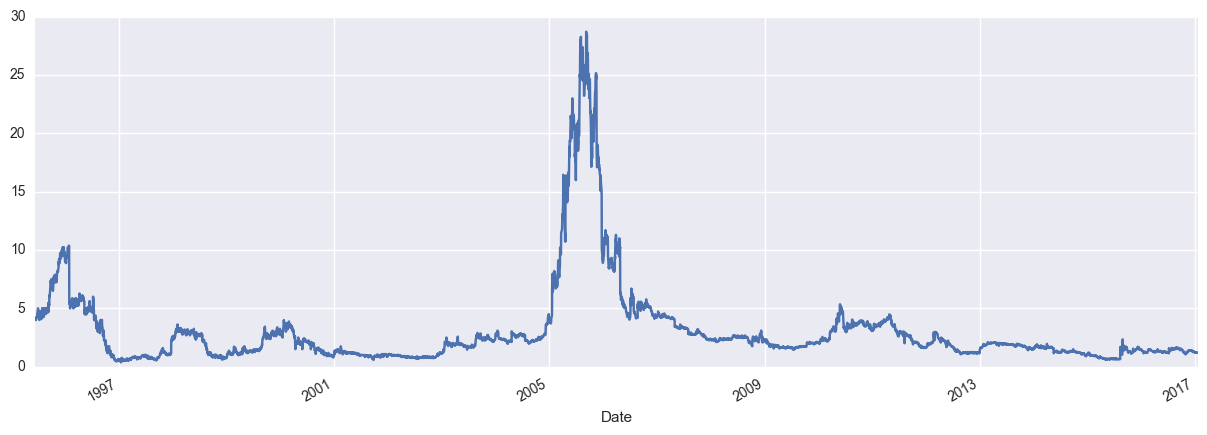

In [14]:
stocks_df['Close'].plot(figsize=(15,5))

### First Difference

We can consider analyzing a first difference of the series. value of (t-1) is subtracted from value of (t).

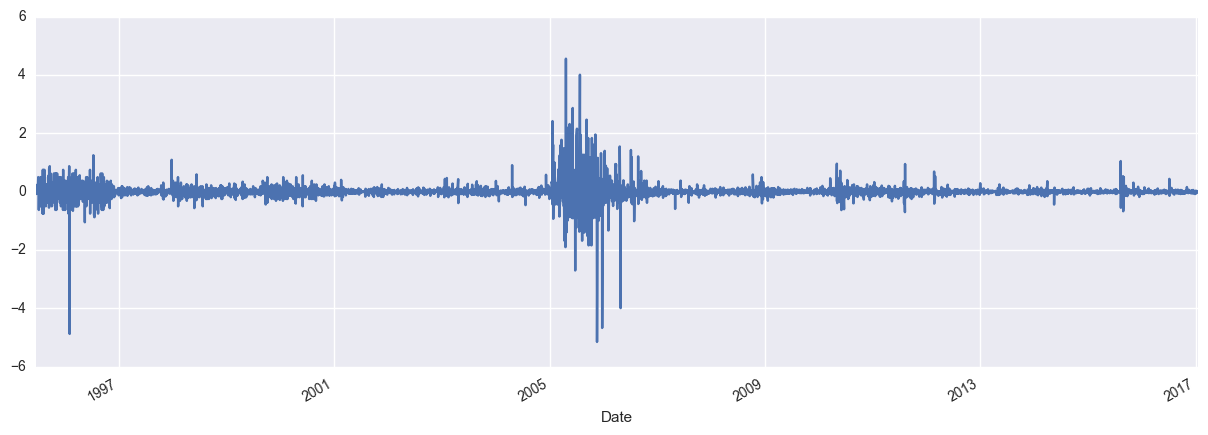

In [15]:
stocks_df['First_Difference'] = stocks_df['Close'] - stocks_df['Close'].shift()
stocks_df['First_Difference'].plot(figsize=(15,5))

First difference is relatively stationary and mostly fluctuates around 0. But variance of this series can vary over time. We need to incorporate mechanism to accomodate for sensing smaller variances along with the larger ones. Hence, Log.

### Log

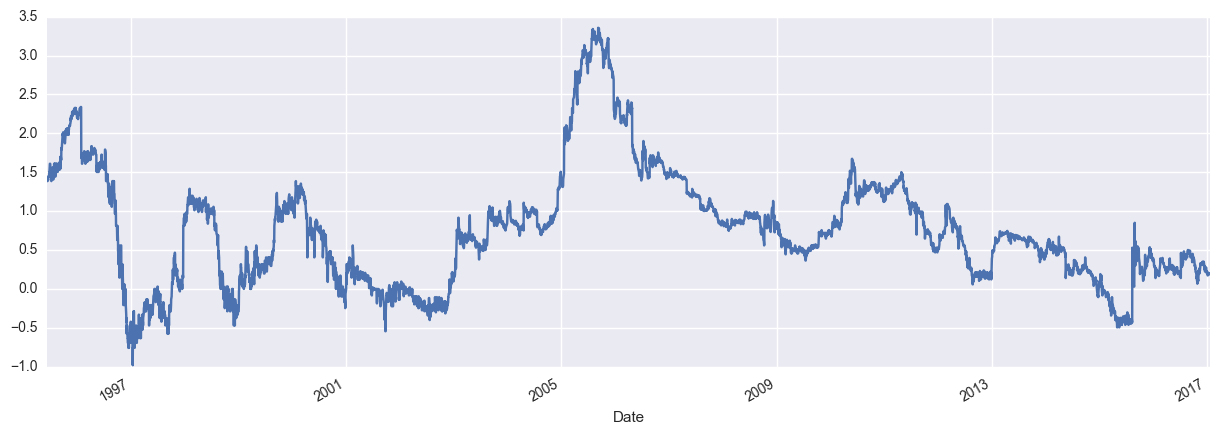

In [16]:
stocks_df['Natural_Log'] = stocks_df['Close'].apply(lambda x: np.log(x))
stocks_df['Natural_Log'].plot(figsize=(15,5))

So that gives us the original closing price with a log transform applied to "flatten" the data from an exponential curve to a linear curve. One way to visually see the effect that the log transform had is to analyze the variance over time. We can use a rolling variance statistic and compare both the original series and the logged series.

### Variance - with and without Log

In [17]:
#Original Rolling Variance
stocks_df['Original_Rolling_Variance'] = stocks_df['Close'].rolling(window = 30, min_periods=None, freq=None, center=True).var()

#Log Rolling Variance
stocks_df['Log_Rolling_Variance'] = stocks_df['Natural_Log'].rolling(window = 30, min_periods=None, freq=None, center=True).var()

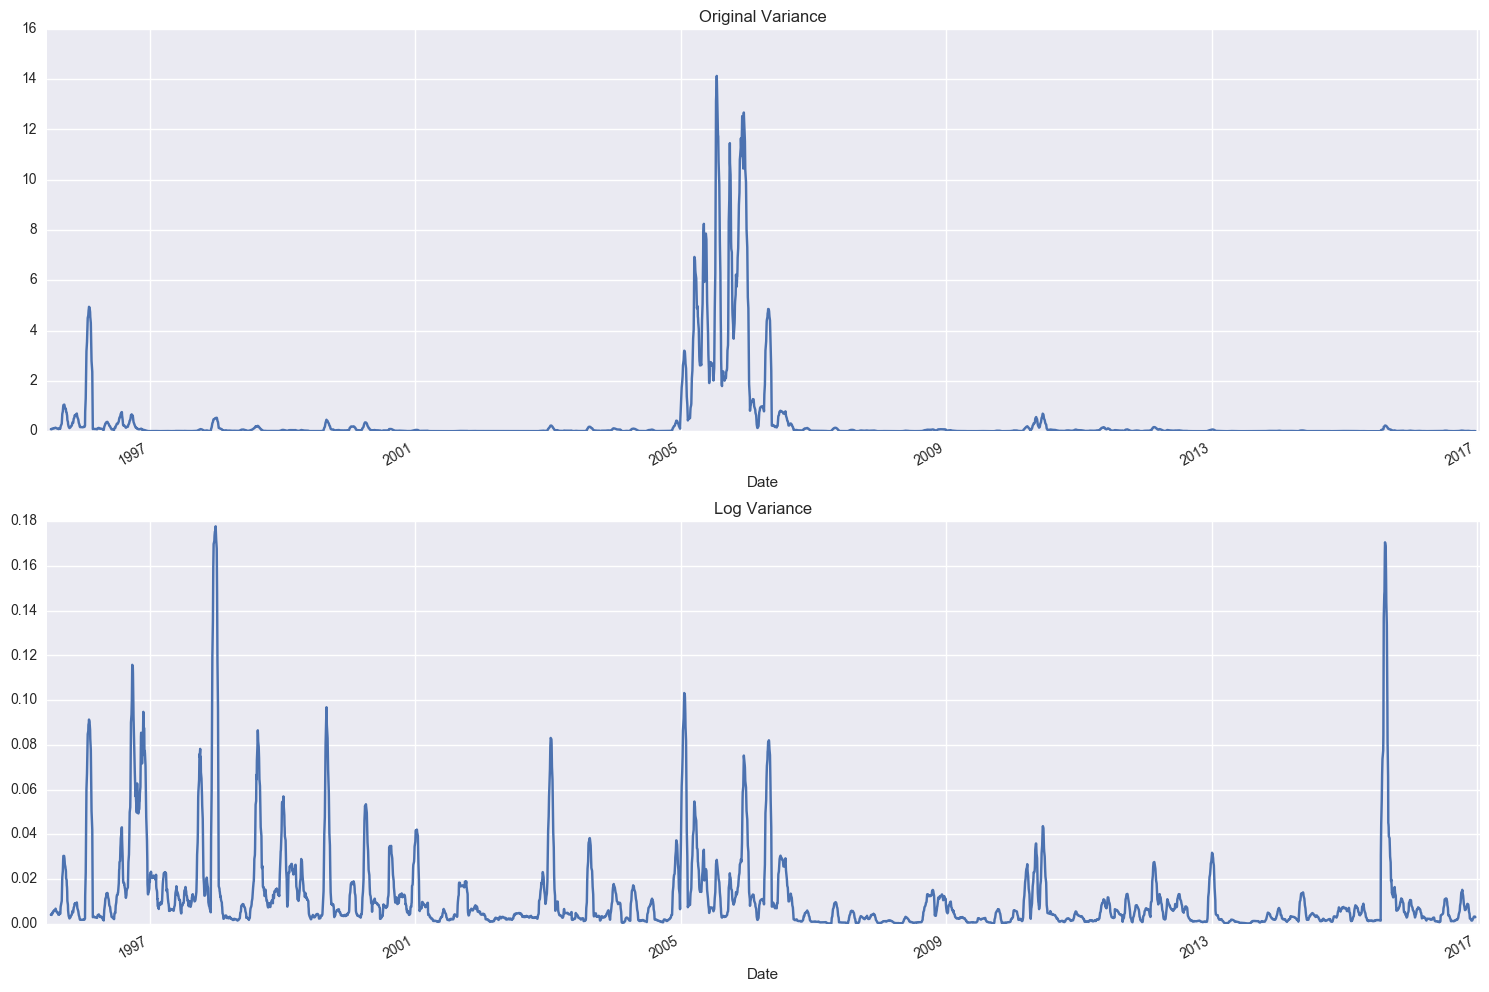

In [18]:
fig, ax = plt.subplots(2,1, figsize = (15,10))
stocks_df['Original_Rolling_Variance'].plot(ax=ax[0],title='Original Variance')
stocks_df['Log_Rolling_Variance'].plot(ax=ax[1],title='Log Variance')
fig.tight_layout()

### Normal and Logged First Difference

In [19]:
#Original Rolling Variance
#stocks_df['First_Difference']

#Log Rolling Variance
stocks_df['Log_First_Difference'] = stocks_df['Natural_Log'] - stocks_df['Natural_Log'].shift()

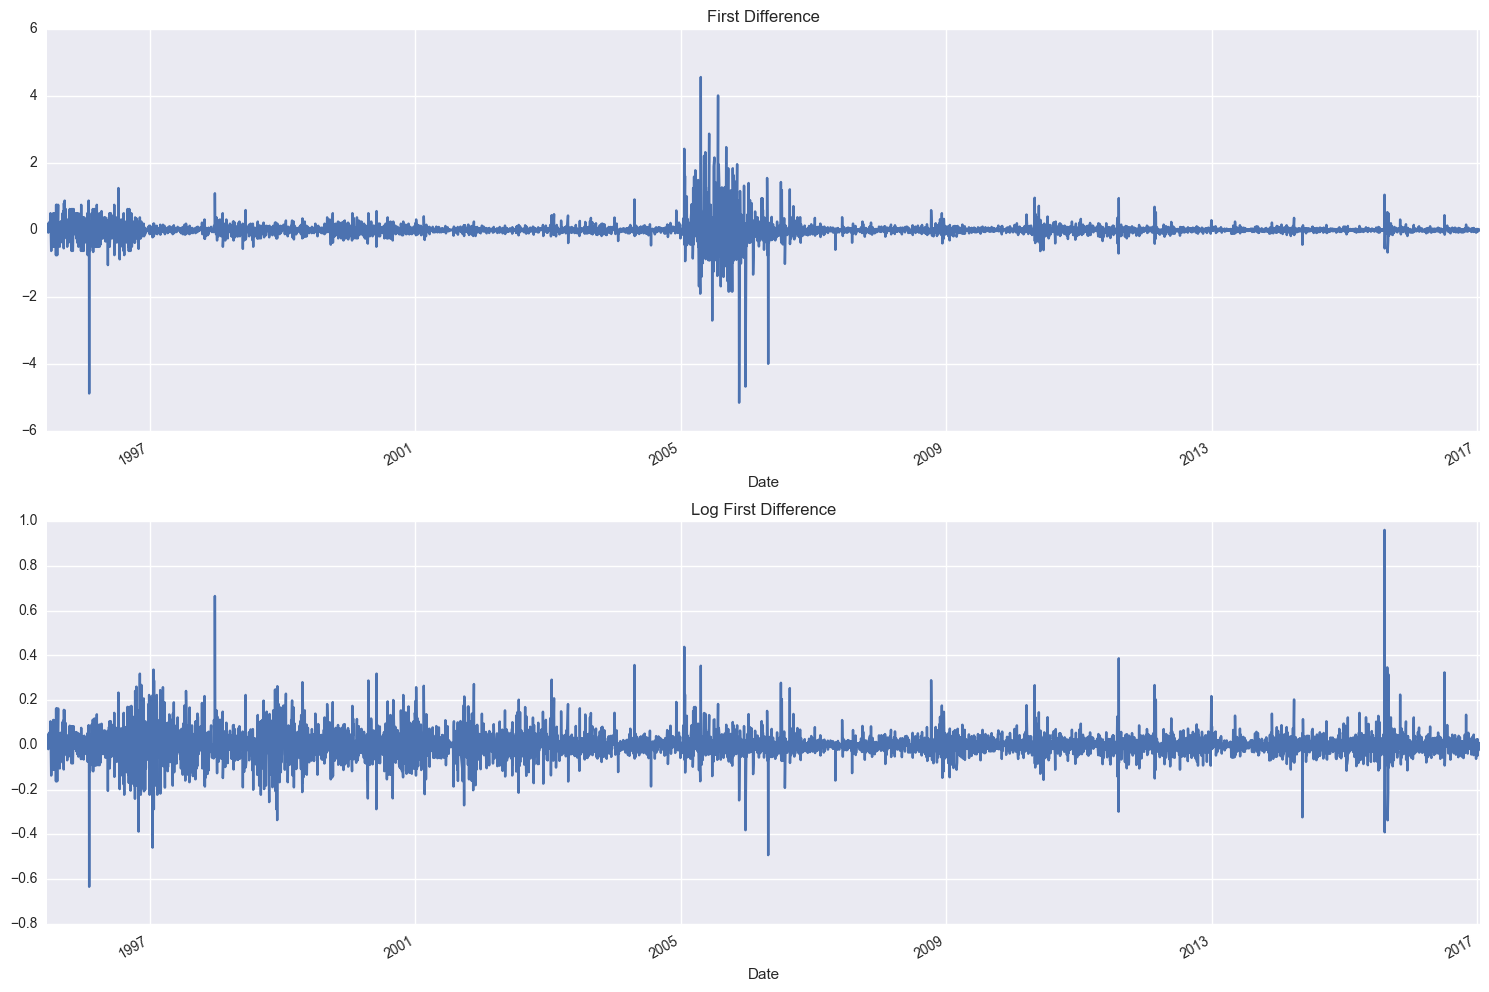

In [20]:
fig, ax = plt.subplots(2,1, figsize = (15,10))
stocks_df['First_Difference'].plot(ax=ax[0],title='First Difference')
stocks_df['Log_First_Difference'].plot(ax=ax[1],title='Log First Difference')
fig.tight_layout()

### Create a few more lag variables

In [21]:
stocks_df['Lag_1'] = stocks_df['Log_First_Difference'].shift()
stocks_df['Lag_2'] = stocks_df['Log_First_Difference'].shift(2)
stocks_df['Lag_5'] = stocks_df['Log_First_Difference'].shift(5)
stocks_df['Lag_30'] = stocks_df['Log_First_Difference'].shift(30)

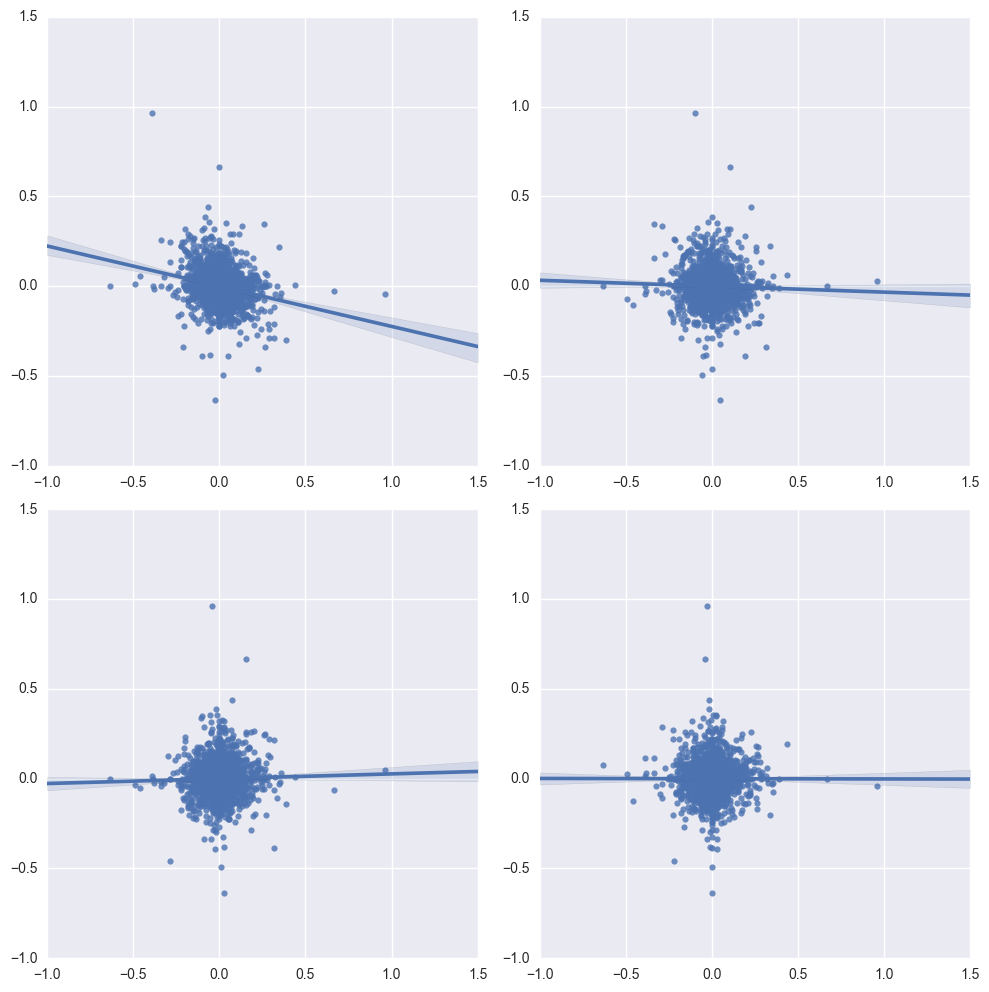

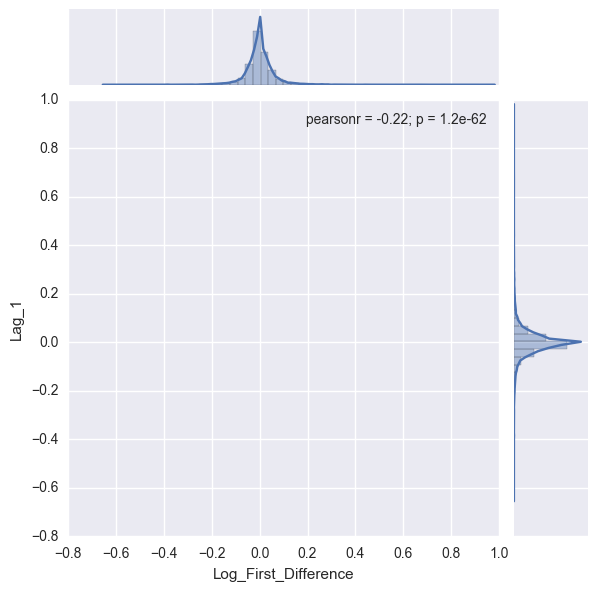

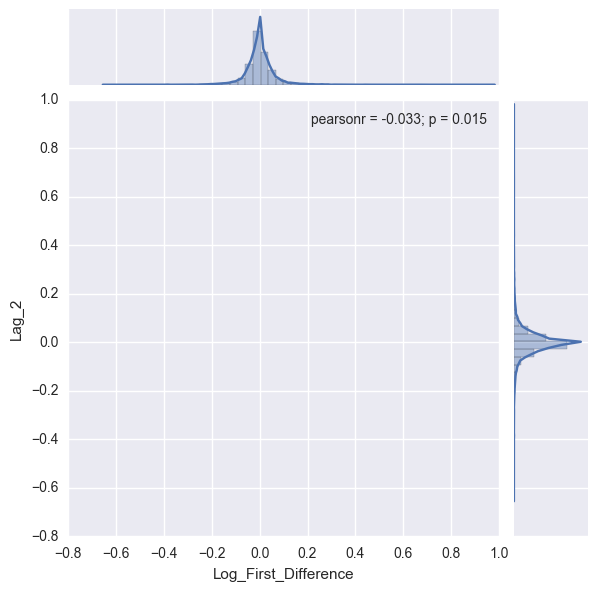

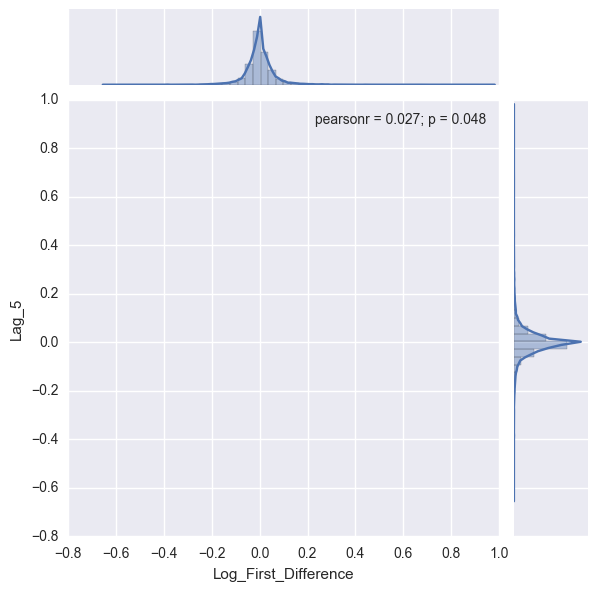

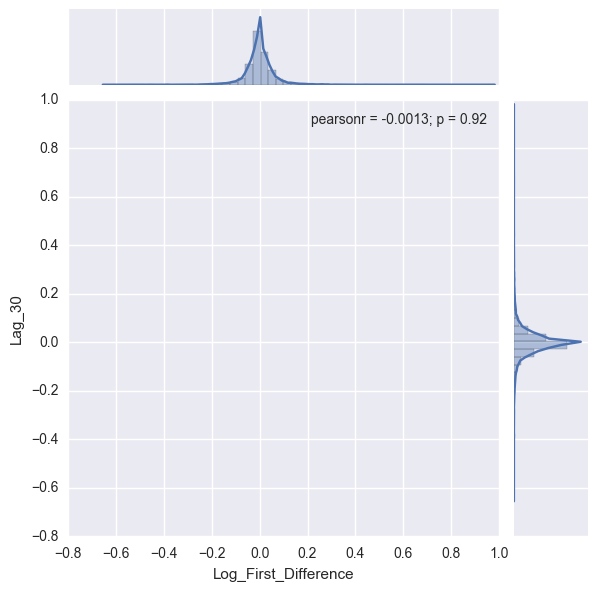

In [37]:
fig, ax = plt.subplots(2,2, figsize = (10,10))
sns.jointplot('Log_First_Difference','Lag_1', stocks_df,kind = 'reg',ax=ax[0,0])
sns.jointplot('Log_First_Difference','Lag_2',stocks_df,kind = 'reg',ax=ax[0,1])
sns.jointplot('Log_First_Difference','Lag_5',stocks_df,kind = 'reg',ax=ax[1,0])
sns.jointplot('Log_First_Difference','Lag_30',stocks_df,kind = 'reg',ax=ax[1,1])
fig.tight_layout()

#### No apparent Correlation. It means that today's index values does not tell much about at least a few days in the future.

### Lag relationships

There could be relation in the values we did not try. There is a function to test those relationships. Let's try those.

In [38]:
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf

In [56]:
lag_correlations = acf(stocks_df['Log_First_Difference'].iloc[1:].values)
#lag_correlations is an array
lag_partial_correlations = pacf(stocks_df['Log_First_Difference'].iloc[1:].values)
#Array as well

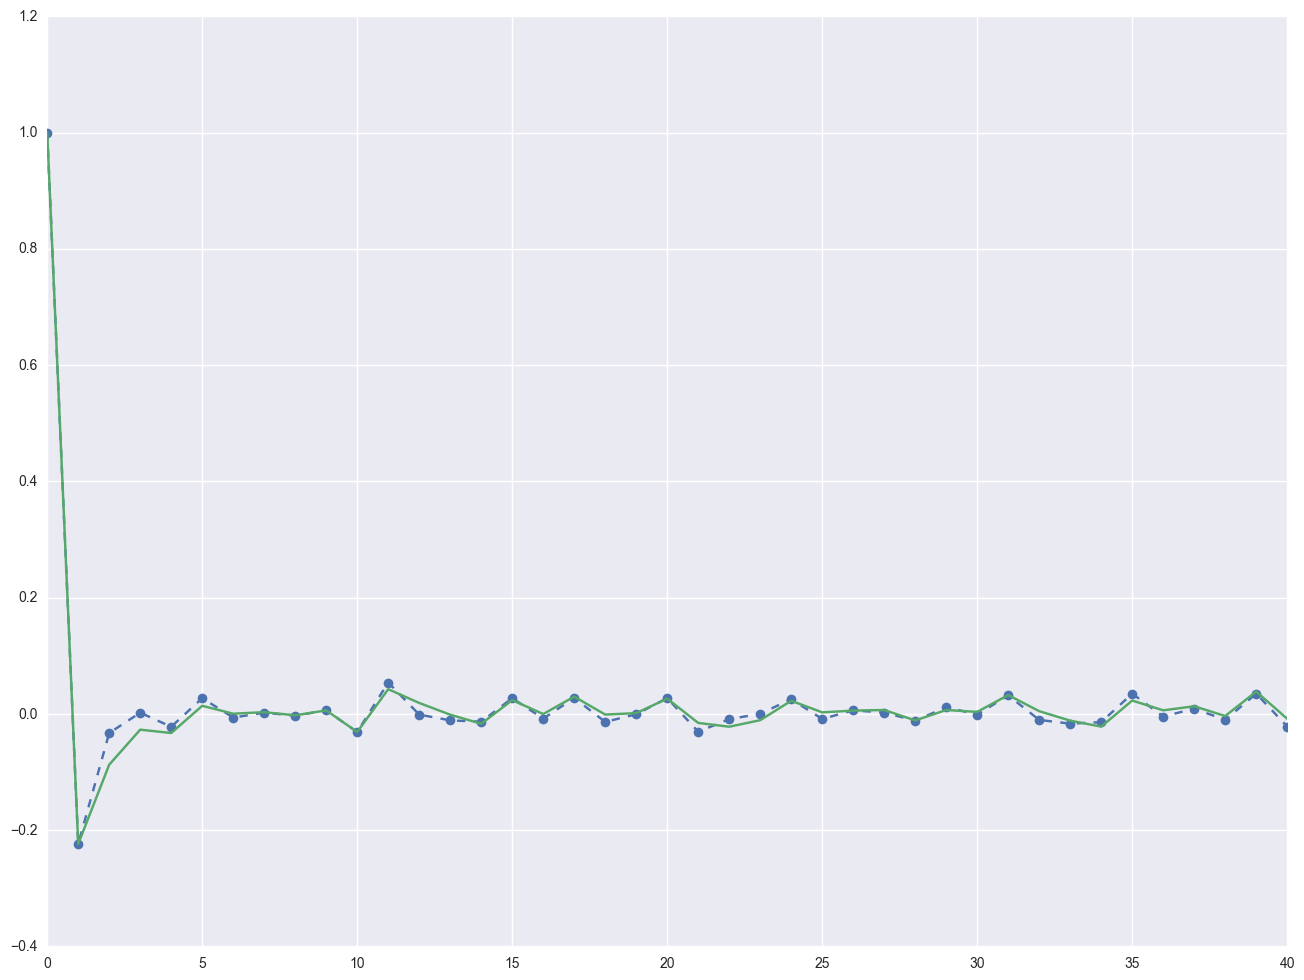

In [68]:
fig, ax = plt.subplots(figsize=(16,12))  
ax.plot(lag_correlations, marker='o', linestyle='--')
ax.plot(lag_partial_correlations, marker='x')

No apparent correlation, this is a random walk

### Seasonal Decomposition

In [70]:
from statsmodels.tsa.seasonal import seasonal_decompose  

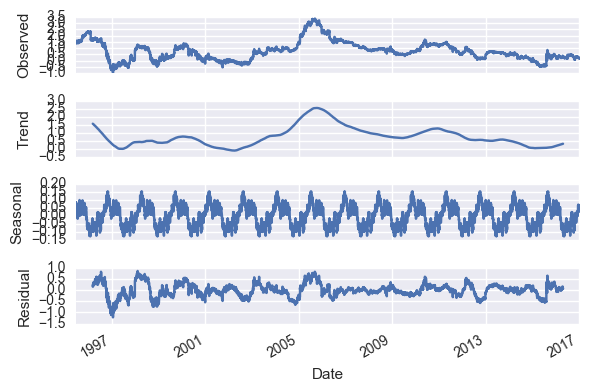

In [80]:
decomposition = seasonal_decompose(stocks_df['Natural_Log'], model='additive', freq=365)  
fig = plt.figure()  
fig = decomposition.plot()  

### ARIMA

Let's try fitting simple average model

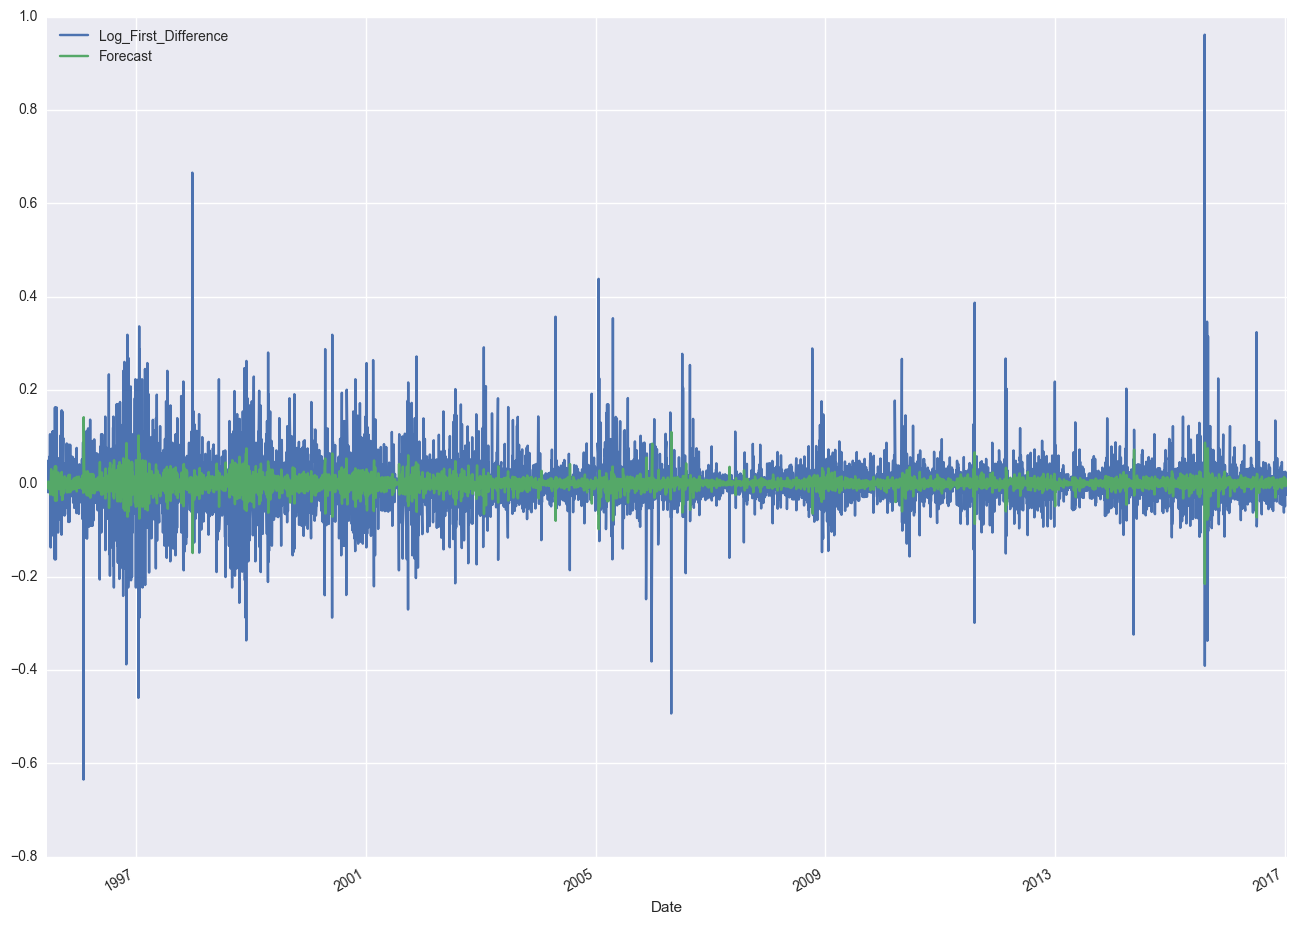

In [86]:
import statsmodels.api as sm  
model = sm.tsa.ARIMA(stocks_df['Natural_Log'].iloc[1:], order=(1, 1, 0))  
results = model.fit(disp=-1)
stocks_df['Forecast'] = results.fittedvalues
stocks_df[['Log_First_Difference','Forecast']].plot(figsize=(16,12))

This is not a good fit. Let's look at the subset

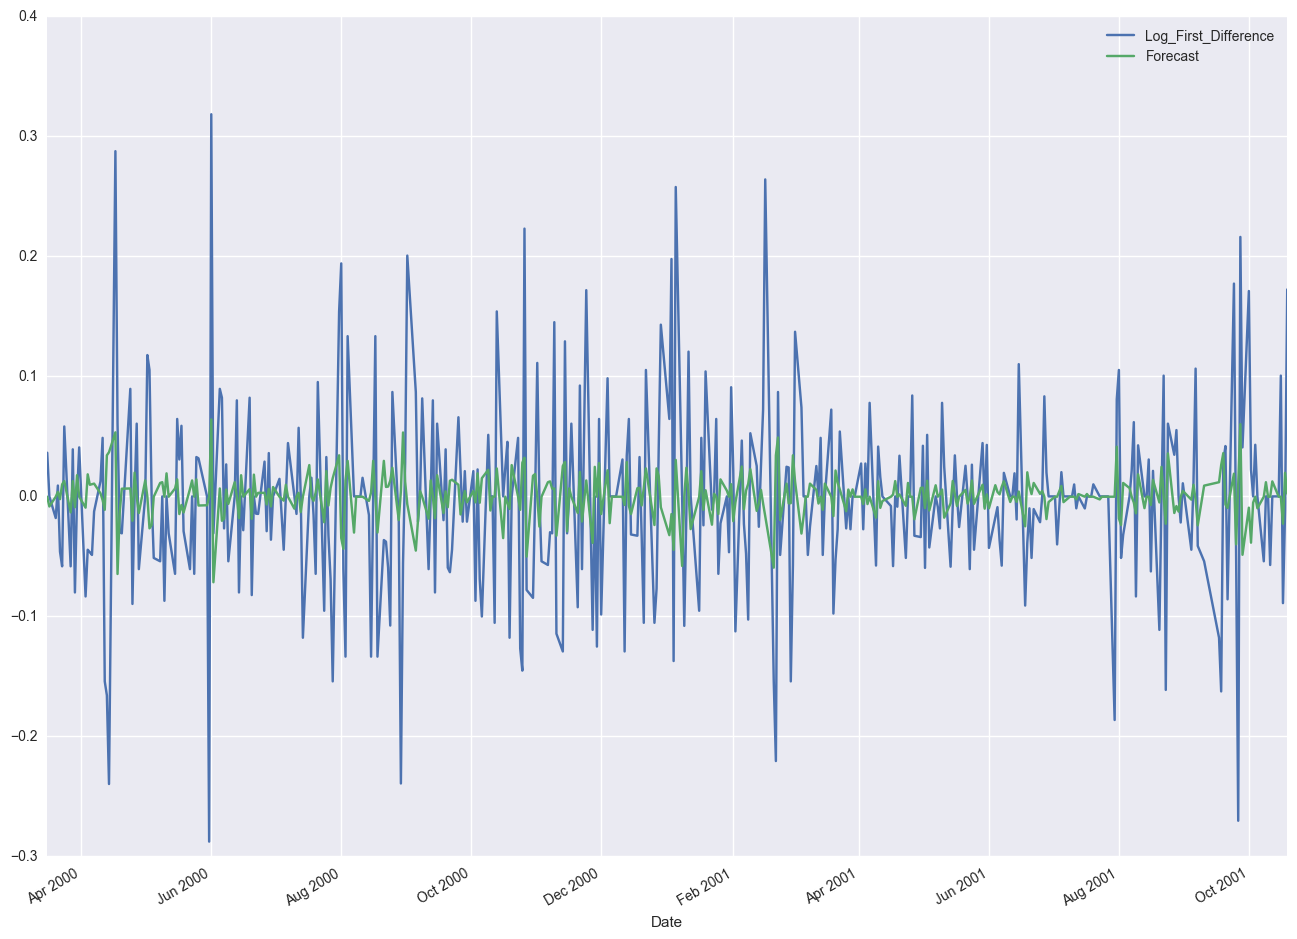

In [89]:
stocks_df[['Log_First_Difference','Forecast']].iloc[1200:1600, :].plot(figsize=(16,12))

#### Let's try exponential

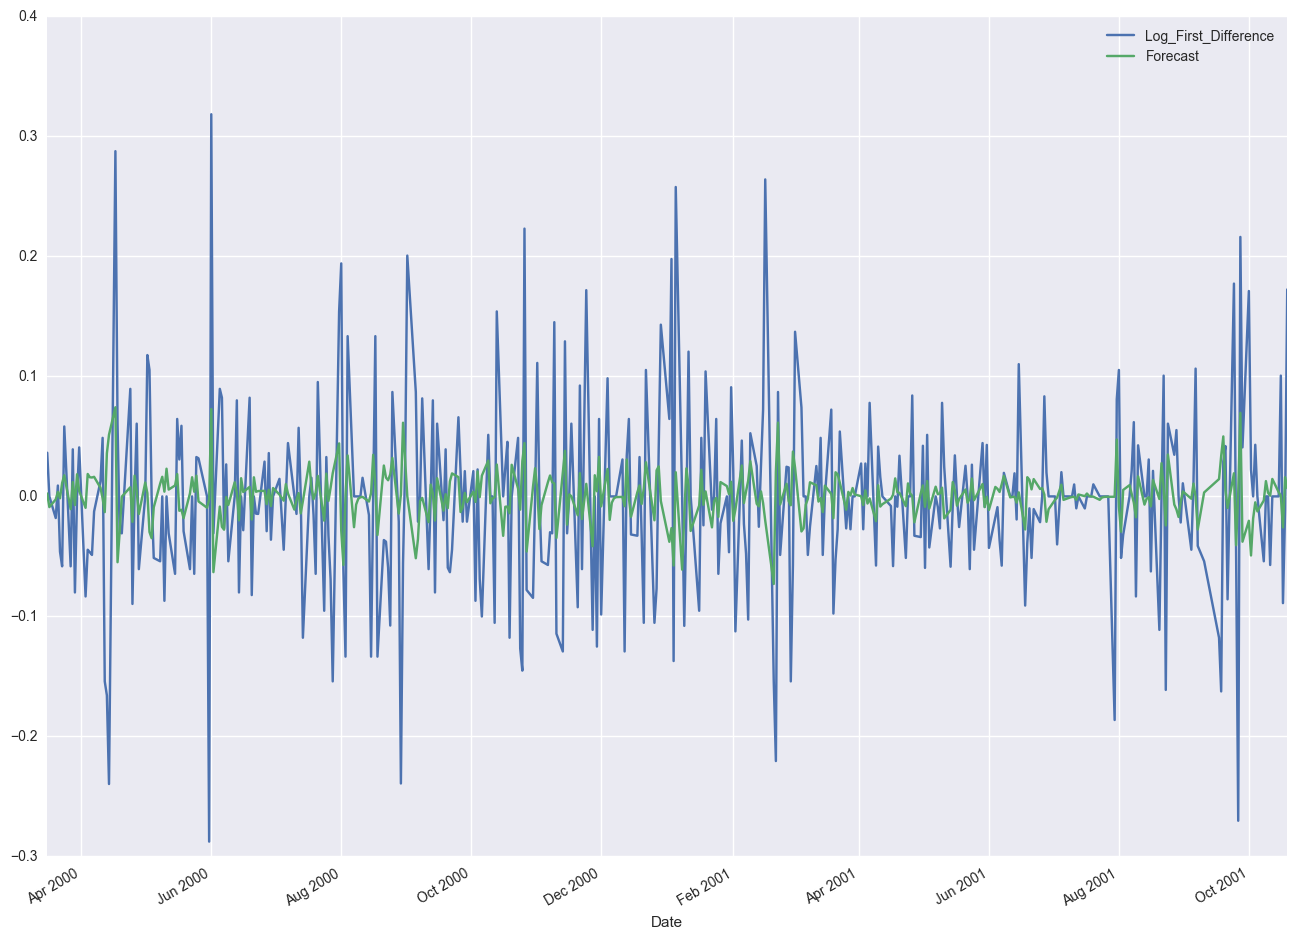

In [90]:
model = sm.tsa.ARIMA(stocks_df['Natural_Log'].iloc[1:], order=(0, 1, 1))  
results = model.fit(disp=-1)
stocks_df['Forecast'] = results.fittedvalues
stocks_df[['Log_First_Difference','Forecast']].iloc[1200:1600,:].plot(figsize=(16,12))